# The (Very) Short Introduction to EasyTS

**Author:** Hannu Parviainen <br>
**Edited:** 9 August 2024

This notebook is a less verbose version of the (not so) short introduction into transmission spectroscopy with EasyTS, showing how a typical transmission spectroscopy analysis would look like without all the comments and more useful to be used as a template for a new analysis.

In [1]:
%run ../setup_multiprocessing.py

In [2]:
%matplotlib inline

In [3]:
from multiprocessing import Pool
from xarray import load_dataset
from matplotlib.pyplot import subplots, setp
from numpy import geomspace, linspace

from easyts import EasyTS, TSData

## Data preparation

In [4]:
def read_data(fname):
    with load_dataset(fname) as ds:
        return TSData(time=ds.time.values, wavelength=ds.wavelength.values, fluxes=ds.flux.values, errors=ds.error.values)

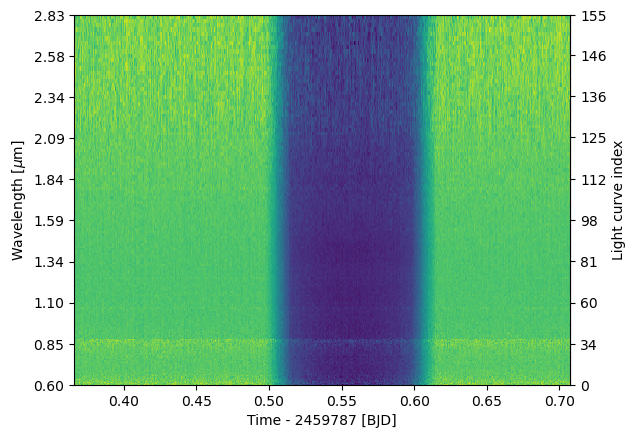

In [5]:
d1 = read_data('data/nirHiss_order_1.h5')
d1.remove_outliers()

d2 = read_data('data/nirHiss_order_2.h5')
d2.crop_wavelength(0.6, d1.wllims[0])
d2.remove_outliers()

db = d2.bin_wavelength(r = 100) + d1.bin_wavelength(r = 100)
ax = db.plot()

## Transmission spectroscopy
### Initialize EasyTS and set the priors

In [7]:
ts = EasyTS('01a_lowres_power2', ldmodel='power-2', data=db, nk=50, nldc=10, nthreads=1)
ts.set_prior('tc', 'NP', 2459694.286, 0.003)
ts.set_prior('p', 'NP', 4.05487, 1e-5)
ts.set_radius_ratio_prior('UP', 0.14, 0.15)
ts.set_ldtk_prior(teff=(5327, 139), logg=(4.38, 0.09), metal=(-0.01, 0.1), uncertainty_multiplier=10)

In [10]:
ts.ps

[  0 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   1 |G| tc             N(μ = 2459694.286, σ = 0.003)            [    -inf ..      inf],
   2 |G| p              N(μ = 4.05487, σ = 1e-05)                [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   4 |G| secw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   5 |G| sesw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   6 |G| ldc1_00.60334  N(μ = 0.732, σ = 0.016)                  [    -inf ..      inf],
   7 |G| ldc2_00.60334  N(μ = 0.809, σ = 0.029)                  [    -inf ..      inf],
   8 |G| ldc1_00.84981  N(μ = 0.594, σ = 0.014)                  [    -inf ..      inf],
   9 |G| ldc2_00.84981  N(μ = 0.694, σ = 0.024)                  [    -inf ..      inf],
  10 |G| ldc1_01.09627  N(μ = 0.543, σ = 0.012)                  [    -inf ..      inf],
  11 |G| ldc2_01.0962

### Customize the radius ratio knot locations

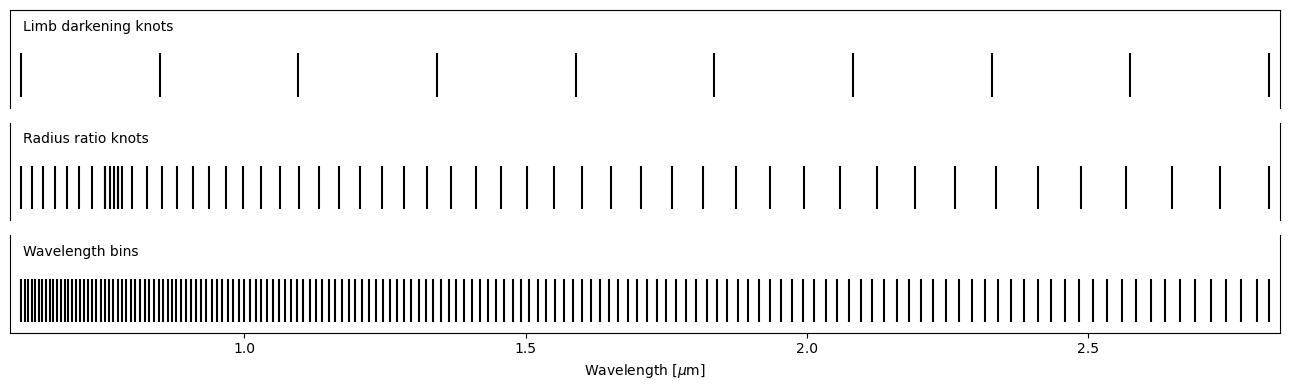

In [9]:
ts.set_radius_ratio_knots(geomspace(*ts.wavelength[[0, -1]], 50))
ts.add_radius_ratio_knots(linspace(0.768-0.015, 0.768+0.015, 5))
ts.set_radius_ratio_prior('UP', 0.14, 0.15)
ts.plot_setup();

### Fit the white light curve

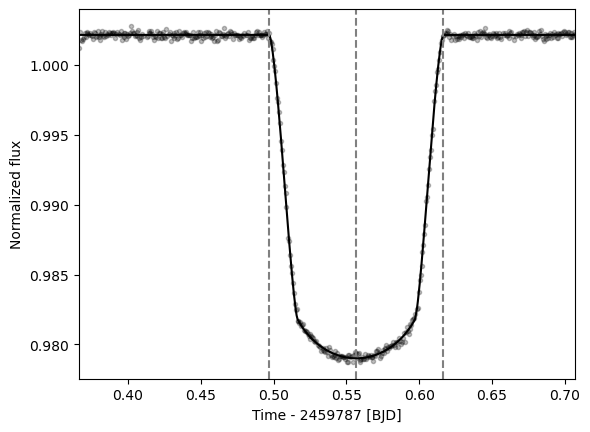

In [15]:
ts.fit_white()
fig = ts.plot_white()

### Normalise the baseline

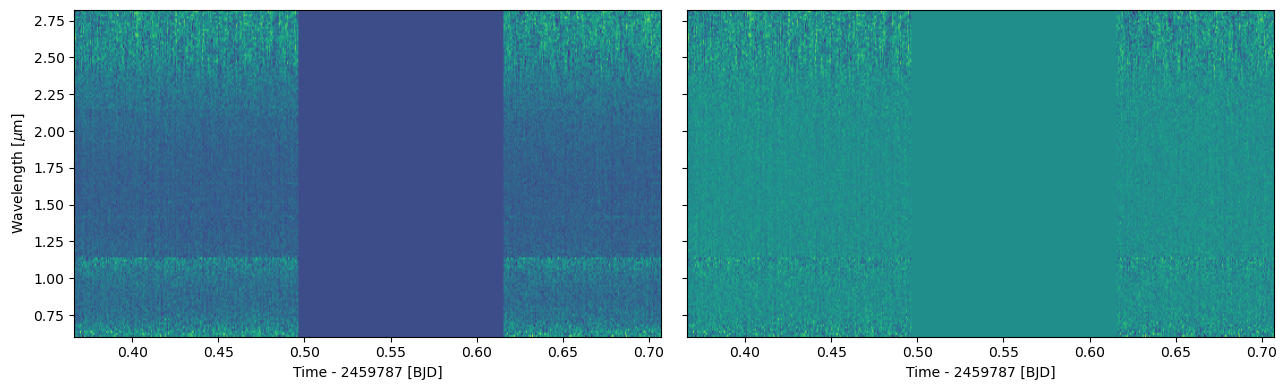

In [16]:
ts.normalize_baseline(1)
fig = ts.plot_baseline()

### Set up multiprocessing

In [18]:
def lnpostf(pv):
    return ts.lnposterior(pv)

In [19]:
pool = Pool(8)

### Fit the transmission spectrum

In [ ]:
ts.fit(niter=6000, npop=250, pool=pool, lnpost=lnpostf)

Global optimisation:   0%|          | 0/6000 [00:00<?, ?it/s]

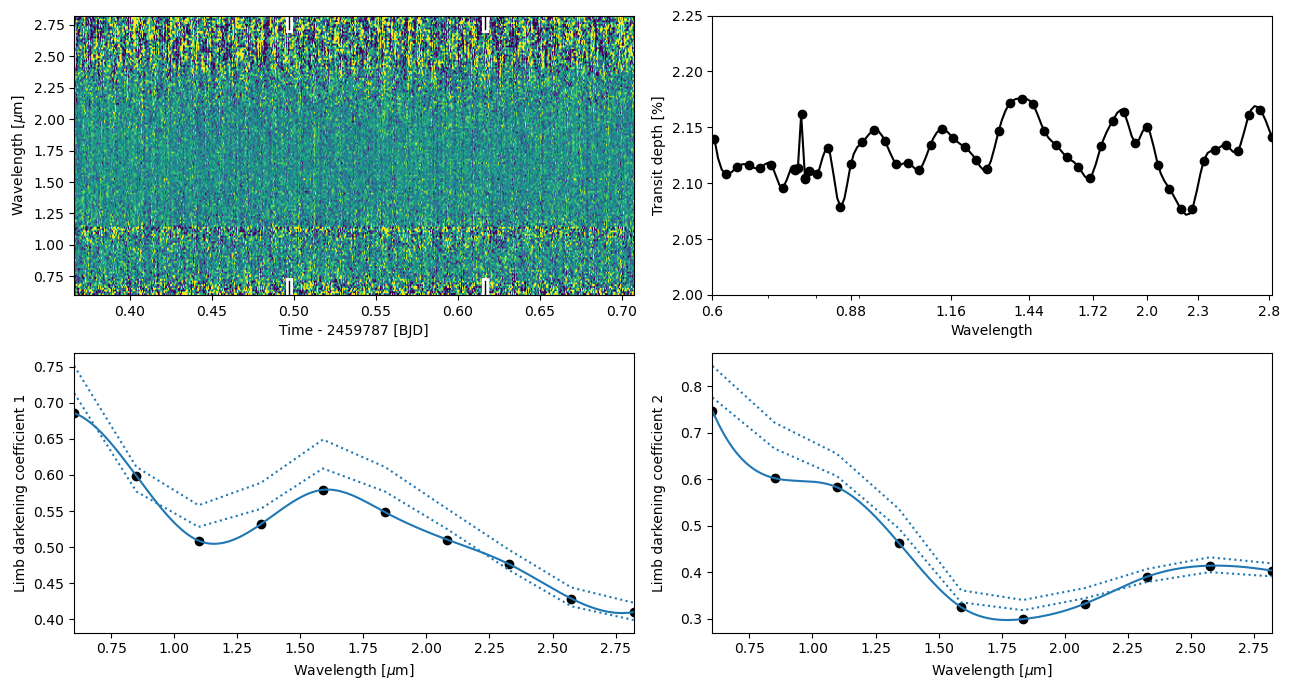

In [67]:
fig, axs = subplots(2, 2, figsize=(13,7))
ts.plot_residuals(axs[0,0], pmin=5, pmax=95)
ts.plot_transmission_spectrum(ax=axs[0,1], xscale='log', ylim=(2.0,2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8])
ts.plot_limb_darkening_parameters('fit', axs=axs[1]);
fig.align_ylabels()

### MCMC sampling

In [69]:
ts.set_ldtk_prior(teff=(5327, 139), logg=(4.38, 0.09), metal=(-0.01, 0.1), uncertainty_multiplier=100)

In [ ]:
ts.sample(1000, thin=100, repeats=3, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/1000 [00:00<?, ?it/s]

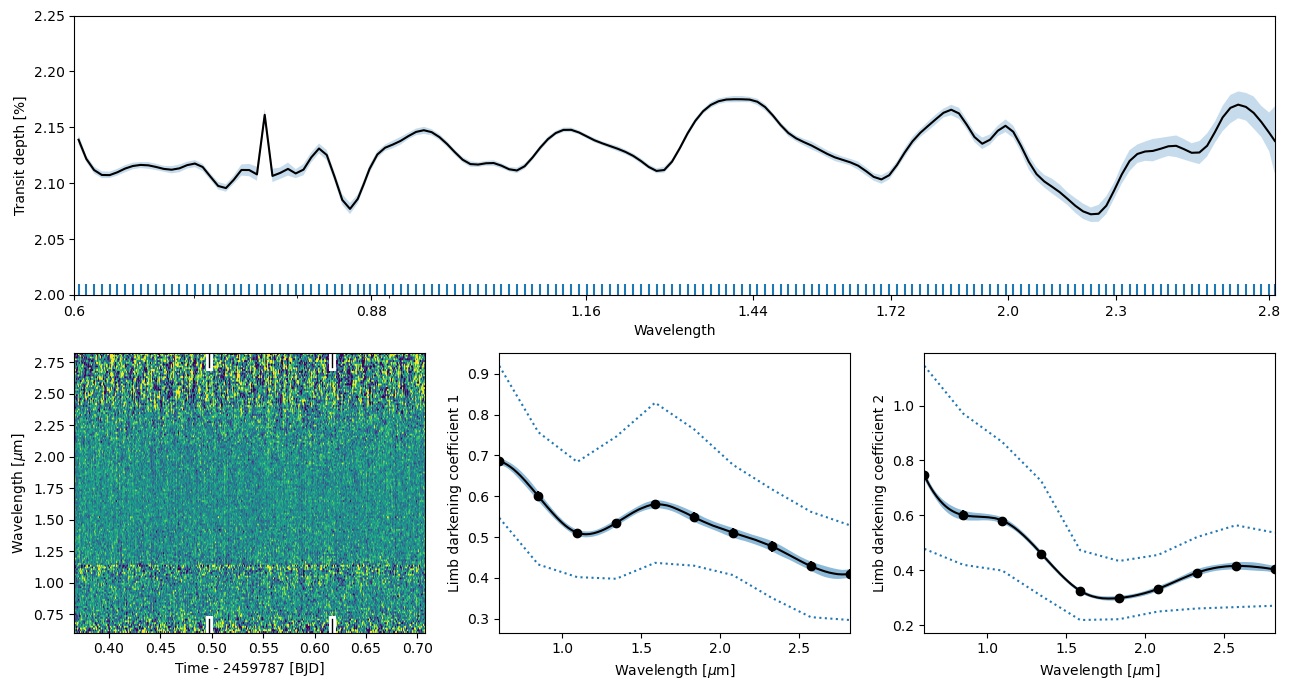

In [101]:
from matplotlib.gridspec import GridSpec
from matplotlib.figure import Figure

fig = Figure(figsize=(13,7))
gs = GridSpec(2,3)
axr = fig.add_subplot(gs[1,0])
ax0 = fig.add_subplot(gs[0,:])
axl = fig.add_subplot(gs[1,1]), fig.add_subplot(gs[1,2])
ts.plot_residuals(axr, pmin=5, pmax=95)
ts.plot_transmission_spectrum(ax=ax0, xscale='log', ylim=(2.0,2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8])
ax0.vlines(ts.wavelength, 0, 2.01)
ts.plot_limb_darkening_parameters('mcmc', axs=axl)
fig.tight_layout()
fig.align_ylabels()
fig

---

<center>&copy;2024 Hannu Parviainen</center>